# Домашнее задание 2: Шумоподавление

In [1]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
def hz_to_mel(freq):
    return 2595 * np.log10(1 + freq / 700)

def mel_to_hz(mel):
    return 700 * (10**(mel / 2595) - 1)

#### Читаем аудио

In [3]:
audio, f_s = sf.read('audio_2025-10-30_01-25-54.ogg')

print(f"{f_s=}")
print(f"{audio.shape=}")
print(f"{f_s=}")

f_s=48000
audio.shape=(280320,)
f_s=48000


#### Функция для вычисления мел-спектрограммы

In [4]:
frame_length = 2048
step_length = 512

M = 40
f_min = 20
f_max = f_s // 2
eps = 1e-10

def compute_mel_spectrogram_from_audio(input_audio):
    mel_min = hz_to_mel(f_min)
    mel_max = hz_to_mel(f_max)
    mel_points = np.linspace(mel_min, mel_max, M + 2)
    hz_points = mel_to_hz(mel_points)
    bin_points = np.floor((frame_length + 1) * hz_points / f_s).astype(int)
    
    H_local = np.zeros((M, frame_length // 2 + 1))
    for i in range(M):
        left = bin_points[i]
        center = bin_points[i + 1]
        right = bin_points[i + 2]
        if left < center:
            H_local[i, left:center] = np.linspace(0, 1, center - left)
        if center < right:
            H_local[i, center:right] = np.linspace(1, 0, right - center)
    
    window = np.arange(frame_length)
    window = 0.5 * (1 - np.cos(2 * np.pi * window / (frame_length - 1)))
    frames_power = []
    
    for frame_start in range(0, len(input_audio) - frame_length, step_length):
        frame_end = frame_start + frame_length
        frame_after_window = input_audio[frame_start:frame_end] * window
        fft_result = np.fft.fft(frame_after_window)
        fft_result = fft_result[:frame_length // 2 + 1]
        fft_abs = np.abs(fft_result) ** 2 / frame_length
        frames_power.append(fft_abs)
    
    P = np.array(frames_power).T
    
    S_mel = np.dot(H_local, P)
    S_mel = np.log(S_mel + eps)
    
    return S_mel

#### Исходная спектрограмма

In [5]:
S_mel_original = compute_mel_spectrogram_from_audio(audio)
print(S_mel_original.shape)

(40, 544)


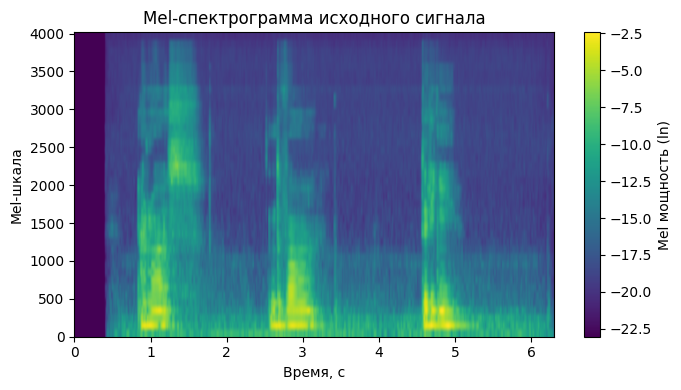

In [6]:
mel_min = hz_to_mel(f_min)
mel_max = hz_to_mel(f_max)
mel_points = np.linspace(mel_min, mel_max, M + 2)
sr = 44100

time = np.arange(S_mel_original.shape[1]) * step_length / sr

plt.figure(figsize=(7, 4))
plt.imshow(S_mel_original, aspect='auto', origin='lower',
           extent=[time[0], time[-1], 0, mel_points[-1]],
           cmap='viridis')
plt.colorbar(label="Mel мощность (ln)")
plt.title("Mel-спектрограмма исходного сигнала")
plt.xlabel("Время, с")
plt.ylabel("Mel-шкала")
plt.tight_layout()
plt.show()

### Добавление шума к аудиосигналу

In [7]:
def add_noise(input_audio, snr_db):
    signal_power = np.mean(input_audio ** 2)
    
    noise = np.random.normal(0, 1, len(input_audio))
    
    noise_power = np.mean(noise ** 2)
    snr_linear = 10 ** (snr_db / 10)
    noise = noise * np.sqrt(signal_power / (noise_power * snr_linear))
    
    noisy_audio = input_audio + noise
    
    max_val = np.max(np.abs(noisy_audio))
    if max_val > 1.0:
        noisy_audio = noisy_audio / max_val * 0.95
    
    return noisy_audio, noise

noisy_audio, noise = add_noise(audio, 5)
S_mel_noisy = compute_mel_spectrogram_from_audio(noisy_audio)

### Осуществляем шумоподавление методом спектрального вычитания

In [8]:
def spectral_subtraction(noisy_audio_input, f_s_input, frame_length_input=2048, step_length_input=512, alpha=2.0, beta=0.01):
    window = np.hamming(frame_length_input)
    
    noise_frames_count = 10
    noise_spectrum = np.zeros(frame_length_input // 2 + 1)
    
    for i in range(noise_frames_count):
        frame_start = i * step_length_input
        frame_end = frame_start + frame_length_input
        frame = noisy_audio_input[frame_start:frame_end] * window
        fft_result = np.fft.fft(frame)
        fft_result = fft_result[:frame_length_input // 2 + 1]
        noise_spectrum += np.abs(fft_result) ** 2
    
    noise_spectrum /= noise_frames_count
    
    cleaned_audio = np.zeros_like(noisy_audio_input)
    
    for frame_start in range(0, len(noisy_audio_input) - frame_length_input, step_length_input):
        frame_end = frame_start + frame_length_input
        frame = noisy_audio_input[frame_start:frame_end] * window
        
        fft_result = np.fft.fft(frame)
        fft_result = fft_result[:frame_length_input // 2 + 1]
        magnitude = np.abs(fft_result)
        phase = np.angle(fft_result)
        
        enhanced_magnitude = magnitude ** 2 - alpha * noise_spectrum
        enhanced_magnitude = np.maximum(enhanced_magnitude, beta * magnitude ** 2)
        enhanced_magnitude = np.sqrt(enhanced_magnitude)
        
        enhanced_fft = enhanced_magnitude * np.exp(1j * phase)
        enhanced_frame = np.real(np.fft.ifft(np.concatenate([enhanced_fft, enhanced_fft[-2:0:-1]])))
        
        overlap_window = np.hanning(frame_length_input)
        cleaned_audio[frame_start:frame_end] += enhanced_frame * overlap_window
    
    return cleaned_audio

cleaned_spectral = spectral_subtraction(noisy_audio, f_s, frame_length, step_length)

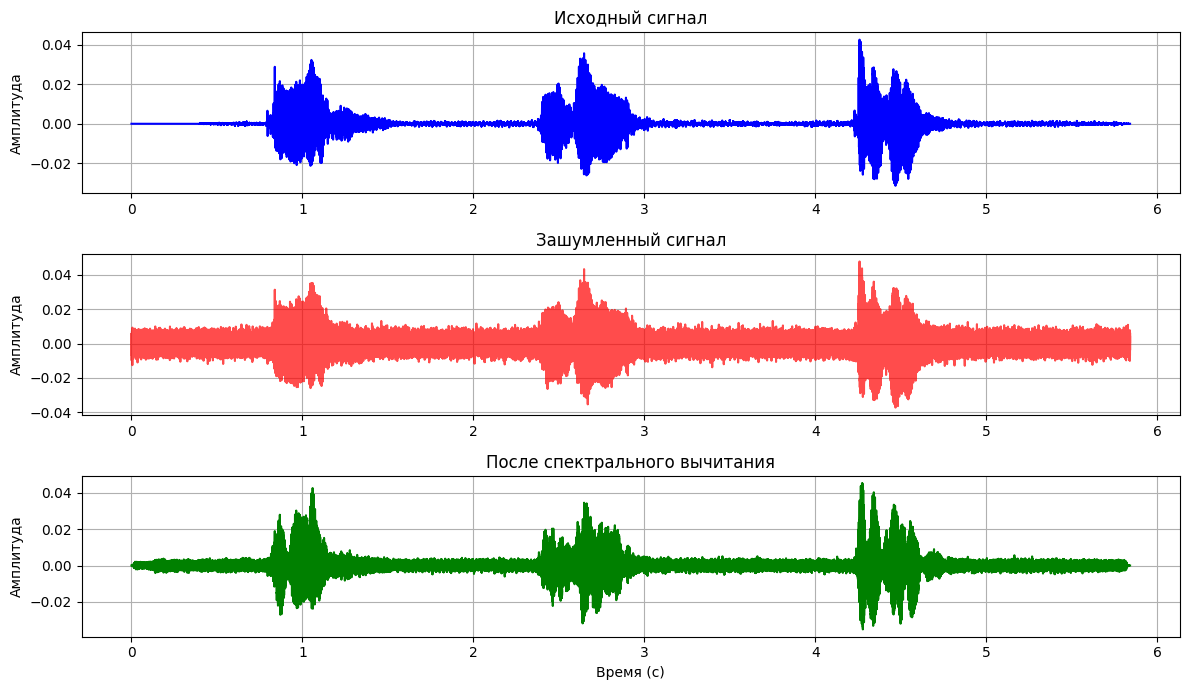

In [9]:
plt.figure(figsize=(12, 7))

plt.subplot(3, 1, 1)
time = np.arange(len(audio)) / f_s
plt.plot(time, audio, color='blue')
plt.title('Исходный сигнал')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, noisy_audio, color='red', alpha=0.7)
plt.title('Зашумленный сигнал')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, cleaned_spectral, color='green')
plt.title('После спектрального вычитания')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.tight_layout()
plt.show()

### Подсчёт метрик качества, визуализации

In [10]:
def calculate_si_sdr(clean_signal, processed_signal):
    alpha = np.dot(processed_signal, clean_signal) / (np.dot(clean_signal, clean_signal) + eps)
    target_signal = alpha * clean_signal
    error_signal = processed_signal - target_signal
    target_power = np.dot(target_signal, target_signal)
    error_power = np.dot(error_signal, error_signal)
    si_sdr = 10 * np.log10(target_power / (error_power + eps))
    return si_sdr

def calculate_stoi(clean_signal, degraded_signal, fs_sample):
    if fs_sample != 16000:
        original_length = len(clean_signal)
        new_length = int(original_length * 16000 / fs_sample)
        clean_indices = np.linspace(0, original_length - 1, new_length)
        degraded_indices = np.linspace(0, original_length - 1, new_length)
        clean_signal_16k = np.interp(clean_indices, np.arange(original_length), clean_signal)
        degraded_signal_16k = np.interp(degraded_indices, np.arange(original_length), degraded_signal)
    else:
        clean_signal_16k = clean_signal
        degraded_signal_16k = degraded_signal
    
    frame_length = 256
    overlap = 0.75
    
    window = np.hanning(frame_length)
    step = int(frame_length * (1 - overlap))
    
    stft_clean = []
    stft_degraded = []
    
    for i in range(0, len(clean_signal_16k) - frame_length, step):
        frame_clean = clean_signal_16k[i:i+frame_length] * window
        frame_degraded = degraded_signal_16k[i:i+frame_length] * window
        
        stft_clean.append(np.abs(np.fft.fft(frame_clean)[:frame_length//2]))
        stft_degraded.append(np.abs(np.fft.fft(frame_degraded)[:frame_length//2]))
    
    stft_clean = np.array(stft_clean).T
    stft_degraded = np.array(stft_degraded).T
    
    correlations = []
    for i in range(min(stft_clean.shape[1], stft_degraded.shape[1])):
        corr = np.corrcoef(stft_clean[:, i], stft_degraded[:, i])[0, 1]
        if not np.isnan(corr):
            correlations.append(corr)
    
    return np.mean(correlations) if correlations else 0

def calculate_mel_spectrogram_sdr(mel_ref, mel_est):
    min_frames = min(mel_ref.shape[1], mel_est.shape[1])
    mel_ref_cropped = mel_ref[:, :min_frames]
    mel_est_cropped = mel_est[:, :min_frames]
    numerator = np.sum(mel_ref_cropped ** 2)
    denominator = np.sum((mel_ref_cropped - mel_est_cropped) ** 2)
    return 10 * np.log10(numerator / (denominator + eps))

def calculate_key_metrics(clean_signal, processed_signal, clean_mel, processed_mel):
    si_sdr_value = calculate_si_sdr(clean_signal, processed_signal)
    stoi_value = calculate_stoi(clean_signal, processed_signal, f_s)
    mel_sdr = calculate_mel_spectrogram_sdr(clean_mel, processed_mel)
    return {
        'si_sdr': si_sdr_value,
        'stoi': stoi_value,
        'mel_sdr': mel_sdr
    }

In [11]:
metrics_results = {}

metrics_results['Зашумленный'] = calculate_key_metrics(
    audio, noisy_audio, S_mel_original, S_mel_noisy
)

S_mel_spectral = compute_mel_spectrogram_from_audio(cleaned_spectral)

metrics_results['Спектральное вычитание'] = calculate_key_metrics(
    audio, cleaned_spectral, S_mel_original, S_mel_spectral
)

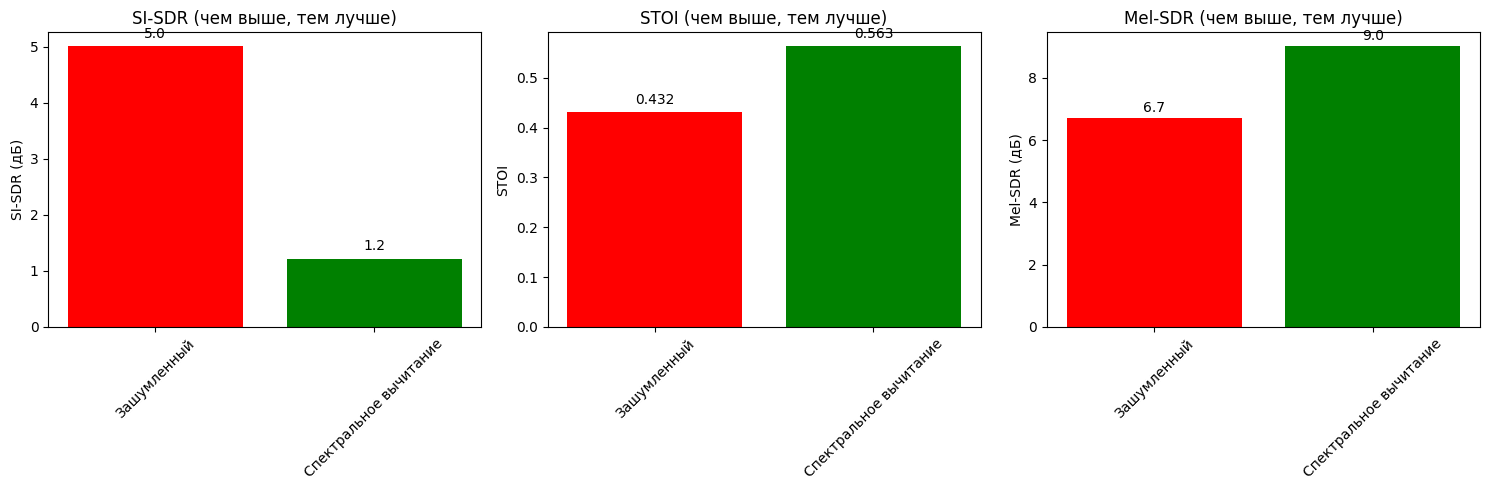

In [12]:
plt.figure(figsize=(15, 5))

algorithms = list(metrics_results.keys())
colors = ['red', 'green']

plt.subplot(1, 3, 1)
si_sdr_values = [metrics_results[alg]['si_sdr'] for alg in algorithms]
bars = plt.bar(range(len(algorithms)), si_sdr_values, color=colors)
plt.title('SI-SDR (чем выше, тем лучше)')
plt.ylabel('SI-SDR (дБ)')
plt.xticks(range(len(algorithms)), algorithms, rotation=45, ha='center')
for bar, value in zip(bars, si_sdr_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.1f}', ha='center', va='bottom')

plt.subplot(1, 3, 2)
stoi_values = [metrics_results[alg]['stoi'] for alg in algorithms]
bars = plt.bar(range(len(algorithms)), stoi_values, color=colors)
plt.title('STOI (чем выше, тем лучше)')
plt.ylabel('STOI')
plt.xticks(range(len(algorithms)), algorithms, rotation=45, ha='center')
for bar, value in zip(bars, stoi_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.subplot(1, 3, 3)
mel_sdr_values = [metrics_results[alg]['mel_sdr'] for alg in algorithms]
bars = plt.bar(range(len(algorithms)), mel_sdr_values, color=colors)
plt.title('Mel-SDR (чем выше, тем лучше)')
plt.ylabel('Mel-SDR (дБ)')
plt.xticks(range(len(algorithms)), algorithms, rotation=45, ha='center')
for bar, value in zip(bars, mel_sdr_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

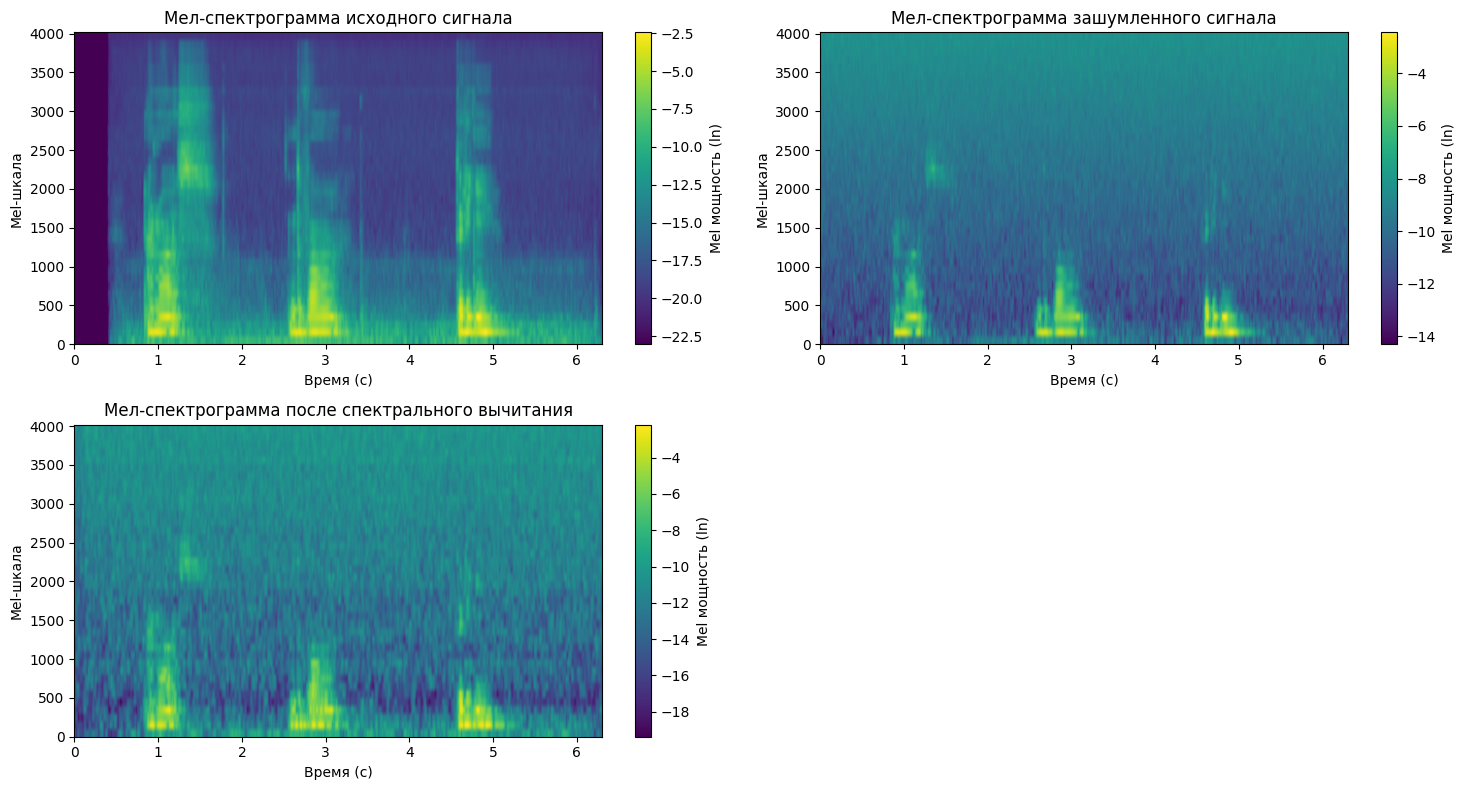

In [13]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
time_mel = np.arange(S_mel_original.shape[1]) * step_length / sr
plt.imshow(S_mel_original, aspect='auto', origin='lower',
           extent=[time_mel[0], time_mel[-1], 0, mel_points[-1]],
           cmap='viridis')
plt.colorbar(label="Mel мощность (ln)")
plt.title("Мел-спектрограмма исходного сигнала")
plt.xlabel("Время (с)")
plt.ylabel("Mel-шкала")

plt.subplot(2, 2, 2)
plt.imshow(S_mel_noisy, aspect='auto', origin='lower',
           extent=[time_mel[0], time_mel[-1], 0, mel_points[-1]],
           cmap='viridis')
plt.colorbar(label="Mel мощность (ln)")
plt.title("Мел-спектрограмма зашумленного сигнала")
plt.xlabel("Время (с)")
plt.ylabel("Mel-шкала")

plt.subplot(2, 2, 3)
plt.imshow(S_mel_spectral, aspect='auto', origin='lower',
           extent=[time_mel[0], time_mel[-1], 0, mel_points[-1]],
           cmap='viridis')
plt.colorbar(label="Mel мощность (ln)")
plt.title("Мел-спектрограмма после спектрального вычитания")
plt.xlabel("Время (с)")
plt.ylabel("Mel-шкала")

plt.tight_layout()
plt.show()